<a href="https://colab.research.google.com/github/EduardoLawson1/Pytorch-Practice/blob/main/Pytorch%20Custom%20Datasets/Pytorch_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 4 of the Pytorch for DeepLearning Bootcamp from ZTM

This section is for how you use you custom datasets with Pytorch

## 0. Importing Pytorch and set up device agnostic code

In [1]:
import torch
from torch import nn

#Note: Pytorch 1.10.0 + is required
torch.__version__

'2.4.0+cu121'

In [2]:
#setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data
Our dataset is a subset of the Food 101 dataset.
The Food dataset starts with 101 different class and 1000 images per class
Our dataset starts with 3 classes of food and only 10% of the images

In [3]:
import requests
import zipfile
from pathlib import Path

#setuo path to a folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#if the foldere doesn't exist download it
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} doesn't exists... creating one")
  image_path.mkdir(parents=True, exist_ok=True)

#Downloading it
with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
  requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading dataset from github")
  f.write(requests.content)

#unzip it
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping it")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi doesn't exists... creating one
unzipping it


## 2. Data preparation and data exploration

In [4]:
import os

def walkthrough_dir(dir_path):
  """walks through dir_path returning its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dir_path}")

walkthrough_dir(image_path)


There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi
There are 0 directories and 78 images in data/pizza_steak_sushi
There are 0 directories and 75 images in data/pizza_steak_sushi
There are 0 directories and 72 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi
There are 0 directories and 25 images in data/pizza_steak_sushi
There are 0 directories and 19 images in data/pizza_steak_sushi
There are 0 directories and 31 images in data/pizza_steak_sushi


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing a image

Let's ride some code to:
1. Get all of the image paths
2. Pick a rando image path using random.choice()
3. Get the image class name using 'pathlib.Path.parent.stem'
4. Open the image with Pillow

Random image path: data/pizza_steak_sushi/test/steak/27415.jpg
Image class: 27415
Image height: 384
Image width: 512


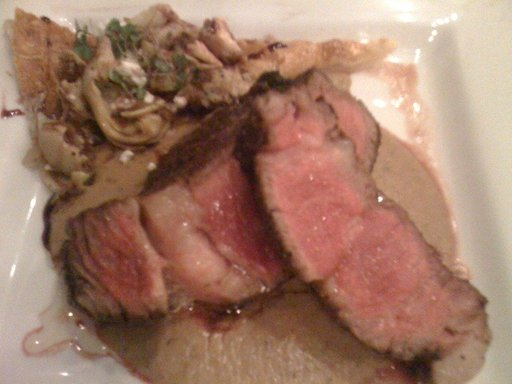

In [6]:
import random
from PIL import Image

#Set seed
#random.seed(42)

# 1. Get the paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a rando image
random_image_path = random.choice(image_path_list)


# 3. Get image class from path name (the class is the name of the directory)
image_class = random_image_path.stem

# 4. OPen image
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

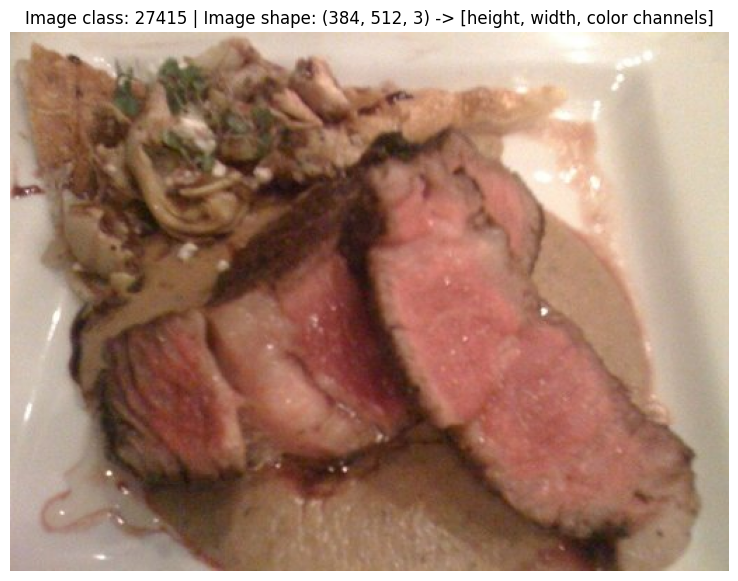

In [7]:
import numpy as np
import matplotlib.pyplot as plt

#Turn the image into an array
img_as_array = np.asarray(img)
#Plot the image with Matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")
plt.axis(False);

## 3. Transforming data
Before we can use our image data with Pytorch:
1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and a subsequently a `torch.utils.data.DataLoader`



In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torch.vision.transforms`

In [9]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #turn the image into a torch tensor
    transforms.ToTensor()
  ])
data_transform(img)

tensor([[[0.7843, 0.8078, 0.8275,  ..., 0.8784, 0.8667, 0.8510],
         [0.7922, 0.7961, 0.7647,  ..., 0.8941, 0.8745, 0.8588],
         [0.7961, 0.7725, 0.6588,  ..., 0.9020, 0.8824, 0.8667],
         ...,
         [0.7216, 0.7216, 0.7216,  ..., 0.7333, 0.6980, 0.6784],
         [0.7137, 0.7137, 0.7176,  ..., 0.7333, 0.7059, 0.6824],
         [0.7059, 0.7098, 0.7098,  ..., 0.7412, 0.7176, 0.6863]],

        [[0.7176, 0.7373, 0.7529,  ..., 0.8196, 0.8196, 0.8078],
         [0.7294, 0.7137, 0.6510,  ..., 0.8392, 0.8275, 0.8118],
         [0.7333, 0.6824, 0.5020,  ..., 0.8392, 0.8275, 0.8118],
         ...,
         [0.6392, 0.6431, 0.6510,  ..., 0.6863, 0.6588, 0.6471],
         [0.6353, 0.6392, 0.6471,  ..., 0.7020, 0.6706, 0.6510],
         [0.6314, 0.6353, 0.6392,  ..., 0.7059, 0.6784, 0.6588]],

        [[0.6314, 0.6588, 0.6627,  ..., 0.7059, 0.7098, 0.7176],
         [0.6510, 0.6275, 0.5490,  ..., 0.7412, 0.7412, 0.7255],
         [0.6549, 0.5843, 0.3569,  ..., 0.7412, 0.7373, 0.

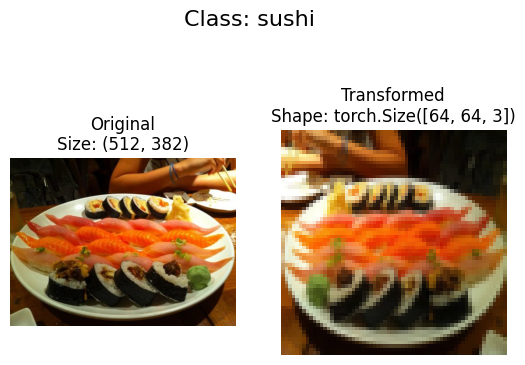

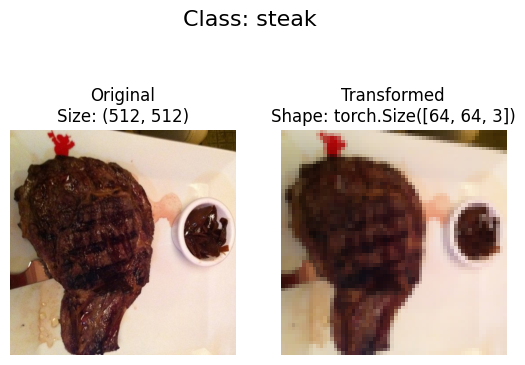

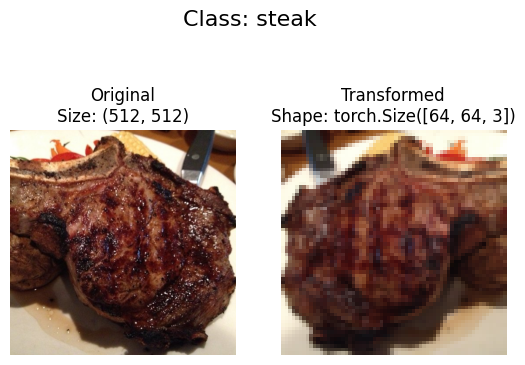

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects rrandom images from a path of images and loads/transfoms them then plots
  the original and the transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)  #going from (C, H, W) for (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis('off')

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)


## 4.Loading image data using ` Image Folder`
###Option 1

We can load image classification data using `torchvision.datasets.ImageFolder`

In [11]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# Get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
#get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [15]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [16]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: \n {img}")
print(f"Image shape:{img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: 
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.

Original shape: torch.Size([3, 64, 64]) -> [C, H, W]
Image permute: torch.Size([64, 64, 3]) -> [H, W C]


Text(0.5, 1.0, 'pizza')

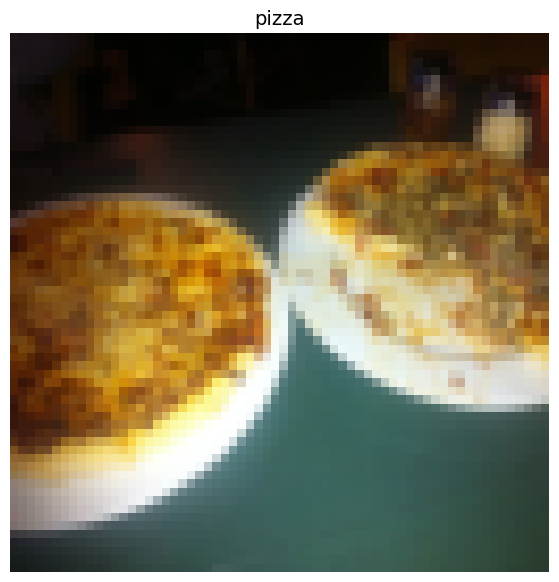

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

#print out different shapes
print(f"Original shape: {img.shape} -> [C, H, W]")
print(f"Image permute: {img_permute.shape} -> [H, W C]")

#Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into DataLoader`s
Using `torch.utils.data.DataLoader`to load data in batches

In [18]:
#Turn train and test datasets into DataLoader
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 12

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False
)

print(f"Using {len(train_dataloader)} batches of {BATCH_SIZE} images")


Using 19 batches of 12 images


In [19]:
img, label = next(iter(train_dataloader))

print(f"image shape {img.shape}")


image shape torch.Size([12, 3, 64, 64])


## 5 Option 2: Loading image data with a custom dataset
1. Able to load images from file
2. ABle to get class names from the dataset
3. Able to get classes as dictionary from the dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to Pytorch pre-built dataset functions

Cons:
* Even though you could create Dataset out of almost anything, it doesn't mean it will work
* Using a custom Dataset often results in us writing more code, wich could be prono to errors or performance issues


In [20]:
import pathlib
from PIL import Image
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

In [21]:
# Instance of torch.vision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using os.scandir() to traverse a target directory
2. Raise an error if the class names aren found
3. Turn the class names into a dict and a list and return them

In [22]:
#setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

#Get the class names from the tarhet directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [23]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory"""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldnt find any classes in {directory}... please check the file structure")

  # 3. Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [24]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a cusom Dataset to replicate ImageFolder()

1. Subclass torch.utils.data.Dataset
2. Init our subclass with a target directory
3. Create several attributes:
* paths - paths of our images
* transform - the transform we'd likje to use
* classes - a list of the target classes
* class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to load_images()
5. Overwrite the __len()__ method to return the length of our dataset
6. Overwrite the __getitem()__ method to return a given sample when passed an index

In [25]:
# 0. write a custom dataset class

#1. #SUbclass torch.utils.dataset
class ImageFolderCustom(Dataset):
  #2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
      #3. Create class attributes
      #get all of the image paths
      self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

      #Setup transforms
      self.transform = transform
      # Create class and class_to_idx
      self.classes, self.class_to_idx = find_classes(targ_dir)

  #4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """Opens an image via a path and returns it"""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    """Returns the total number of samples"""
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """Returns one sample of data, data and label (X, y)."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format data_folder/class_name/image.jpgg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx #return data, label (X, y)
    else:
      return img, class_idx #return untransformed image and label

In [26]:
img, label = train_data[0]

In [27]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


In [28]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                   transform=test_transforms)

In [29]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [30]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [31]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [32]:
# Check for equality between original ImageFolder Dataset and ours
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a dataset and a number of other parameters such as many images to
visualize.

2. TO prevent the display getting out of hand = 10,

3. Set the random seed for reproducibility

4. Get a list of random samples indexes from the target dataset

5. Setup a matplotlib plot

6. Loop through the random sample images and plot them with matplotlib

7. Make sure the dimensions of our images line up with matplotlib(HWC)

In [33]:
# 1. create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjuts display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f" For display purposes, n shouldn't be larger than 10")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4.Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. set the plot
  plt.figure(figsize=(16, 8))
  # 6. Loop through random indexes and plot with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    #7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)  #[C, H, W] -> [H, W, C]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


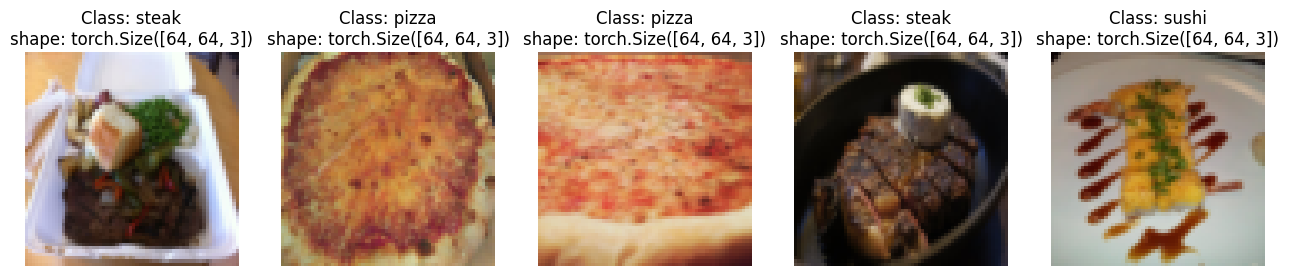

In [34]:
#display random images from the ImageFolder created dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

 For display purposes, n shouldn't be larger than 10


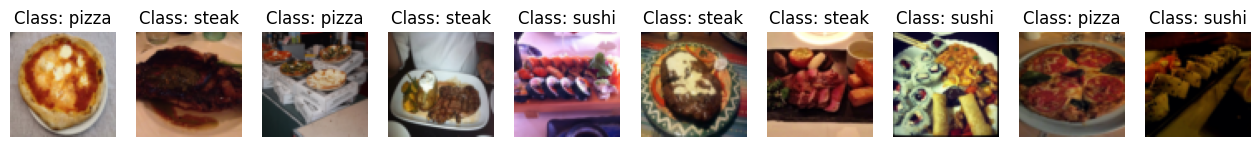

In [35]:
#Display random images from the ImageFolderCustom dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded imagens into Dataloader

In [40]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7eab1273fb50>,
 <torch.utils.data.dataloader.DataLoader at 0x7eab1273cd90>)

In [41]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

#print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms(data augmentation)

Adding diversity to the training data

In [42]:
# Let's look at Trivia Augment
from torchvision import transforms

train_transforms = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                        transforms.Resize(size=(224, 224)),
                                        transforms.ToTensor()

])

In [43]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/1033251.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2811032.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3441394.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/741883.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1524655.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2821048.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2451169.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2569760.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/320570.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2382016.jpg')]

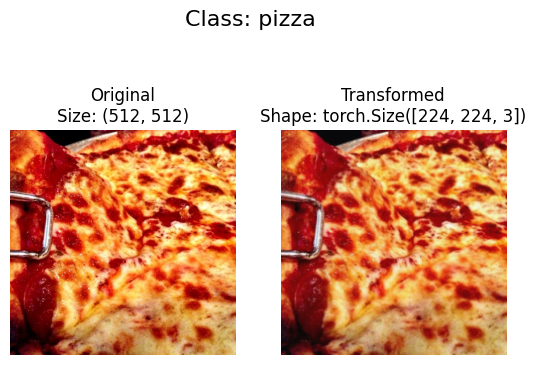

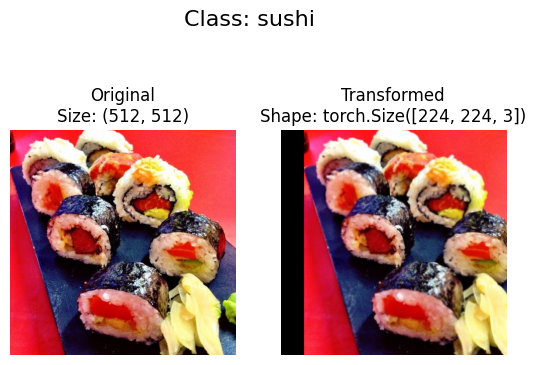

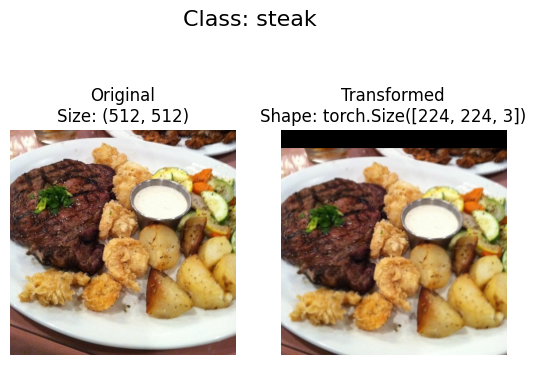

In [45]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None

)